<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [0]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise
# Pattern generation
!pip install imagen

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools, algorithms

# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt

# Computer vision
import cv2
from google.colab.patches import cv2_imshow

# Util
import numpy as np
import random
import math
import operator  # math basic operations

# Operators
from noise import snoise2
import imagen as ig  # Pattern generation

# Upload images
from google.colab import files
from io import BytesIO


## Desenvolvimento

### Inicialização de variáveis

In [0]:
toolbox = base.Toolbox()

#### Imagem de referência

In [0]:
files.upload()

In [0]:
BASE_IMG = cv2.imread('ruined-texture.jpg')

BASE_IMG_WIDTH = BASE_IMG.shape[0];
BASE_IMG_HEIGHT = BASE_IMG.shape[1];
NUMBER_OF_CHANNELS = 3
RGB_MAX = 255;

WHITE_IMG = np.full((BASE_IMG_WIDTH,BASE_IMG_HEIGHT, NUMBER_OF_CHANNELS), RGB_MAX, dtype=np.uint8)

### Util

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()


def plotImage(data):
  plt.axis("off")
  plt.imshow(data, cmap='binary')

  
def convertFloatToUint8(img):
  return cv2.normalize(img, None, RGB_MAX, 0, cv2.NORM_MINMAX, cv2.CV_8UC3);



### Algoritmo

#### Operadores

In [0]:
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html
# https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html

# Patterns generators
tiles = ig.SquareGrating()


# Simplex noise
def perlinNoise(scale, octaves):
  MAX_OCTAVES = 5
  positiveScale = abs(scale) + 1.0
  octavesNormalized = int(octaves) % MAX_OCTAVES + 1
  
  output = np.zeros((BASE_IMG_WIDTH, BASE_IMG_HEIGHT), dtype=np.float)
  for x in range(0, BASE_IMG_WIDTH):
    for y in range(0, BASE_IMG_HEIGHT):
        noiseValue = snoise2(x/positiveScale, y/positiveScale, octaves=octavesNormalized, base=0)
        output[x][y] = noiseValue
  outputUint8 = convertFloatToUint8(output)
  return cv2.cvtColor(outputUint8, cv2.COLOR_GRAY2BGR)


def createTiles(numberOfTilesFloat, orientation):
  MAX_NUMBER_OF_TILES = 10
  numberOfTiles = int(abs(numberOfTilesFloat)) % MAX_NUMBER_OF_TILES + 1
  
  img = tiles(xdensity=BASE_IMG_WIDTH, ydensity=BASE_IMG_HEIGHT, phase=np.pi/2, frequency=numberOfTiles, orientation=orientation)
  imgUint8 = convertFloatToUint8(img)
  return cv2.cvtColor(imgUint8, cv2.COLOR_GRAY2BGR)


def createChessBoard(numberOfLinesFloat):
  numberOfLines = int(abs(numberOfLinesFloat))
  
  horizontal = np.where(createTiles(numberOfLines, 0) == RGB_MAX, 1, 0)
  vertical = np.where(createTiles(numberOfLines, np.pi/2) == RGB_MAX, 1, 0)
  output = np.where(horizontal + vertical > 1, RGB_MAX, 0)
  return np.uint8(output)


def addWeighted(img1, img2, weight):
  GAMMA = 0
  return cv2.addWeighted(img1, weight, img2, 1.0 - weight, GAMMA)


def protectedDiv(left, right):
    return (left / right if right != 0.0 else left)

  
def protectedMod(left, right):
    return (left % right if right != 0.0 else left)


def protectedLog(num, base):
  try:
      return math.log(num, base)
  except:
      return 1


def avg(num1, num2):
  return (num1 + num2) / 2.0

#### Fitness

In [0]:
def calculateHistogram(img):
  channels = [0, 1, 2]
  mask = None
  maxValue = RGB_MAX + 1
  binsPerChannel = [8, 8, 8]
  rangesPerDimension = [0, maxValue, 0, maxValue, 0, maxValue]
  
  hist = cv2.calcHist([img], channels, mask, binsPerChannel, rangesPerDimension)
  hist = cv2.normalize(hist, hist).flatten()
  
  return hist;


def compareHistograms(img1, img2):
  hist1 = calculateHistogram(img1)
  hist2 = calculateHistogram(img2)
  d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
  return d # d está no intervalo [0, 1]


def evalFitness(individual):
  # Transform the tree expression in a callable function
  function = toolbox.compile(expr=individual)
  
  inputs = np.linspace(0, 100, 10)
  output = 0
  for x in np.nditer(inputs):
    for y in np.nditer(inputs):
      output += compareHistograms(BASE_IMG, function(x, y))
  
  mean = output / inputs.shape[0]
  return mean,   # must return a tuple containing one element

#### Estrutura da árvore

In [99]:
#https://gist.github.com/macrintr/9876942

# Define input types and output type
pset = gp.PrimitiveSetTyped("main", [float, float], np.ndarray)
# Rename arguments
pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

# Image operators 
pset.addPrimitive(perlinNoise, [float, float], np.ndarray, "noise")
pset.addPrimitive(createTiles, [float, float], np.ndarray, "listras")
pset.addPrimitive(createChessBoard, [float], np.ndarray, "xadrez")
pset.addPrimitive(addWeighted, [np.ndarray, np.ndarray, float], np.ndarray, "somaImg")

# Float operators
pset.addPrimitive(operator.add, [float, float], float, "soma")
pset.addPrimitive(operator.sub, [float, float], float, "sub")
pset.addPrimitive(operator.mul, [float, float], float, "mult")
pset.addPrimitive(protectedDiv, [float, float], float, "div")
pset.addPrimitive(protectedMod, [float, float], float, "mod")
pset.addPrimitive(math.sin, [float], float, "sen")
pset.addPrimitive(math.cos, [float], float, "cos")
pset.addPrimitive(protectedLog, [float, float], float, "log")
pset.addPrimitive(min, [float, float], float, "min")
pset.addPrimitive(max, [float, float], float, "max")
pset.addPrimitive(avg, [float, float], float, "avg")

# Terminals
pset.addTerminal(WHITE_IMG, np.ndarray, "WHITE")  # required terminal

# Create individual and add tree with primitives
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, pset=pset, fitness=creator.FitnessMax)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Fitness Evaulation
toolbox.register("evaluate", evalFitness)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", gp.cxOnePoint)
# Mutation
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Testes

In [96]:
N_HALL_OF_FAME_INDIVIDUALS = 1
INITIAL_POPULATION_SIZE = 100
CROSSOVER_PROBABILITY = 0.6
MUTATION_PROBABILITY = 0.1
N_GENERATIONS = 10

pop = toolbox.population(n=INITIAL_POPULATION_SIZE)
hof = tools.HallOfFame(N_HALL_OF_FAME_INDIVIDUALS)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, N_GENERATIONS, stats, halloffame=hof)

gen	nevals	avg       	std      	min     	max       
0  	100   	-0.0755201	0.0139166	-0.11526	-0.0602754
1  	68    	-0.0651845	0.00756573	-0.0894512	-0.0602754
2  	61    	-0.0610275	0.003204  	-0.084701 	-0.0602754
3  	69    	-0.0605223	0.00245747	-0.0849739	-0.0602754
4  	72    	-0.060669 	0.00256559	-0.0835074	-0.0602754
5  	68    	-0.0608234	0.00292054	-0.0846582	-0.0602754
6  	67    	-0.0605881	0.00243997	-0.0835308	-0.0602754
7  	54    	-0.0603041	0.000286097	-0.0631507	-0.0602754
8  	72    	-0.0603479	0.000518029	-0.0646223	-0.0602754
9  	76    	-0.061017 	0.00374152 	-0.0835264	-0.0602754
10 	66    	-0.060532 	0.00179706 	-0.0734629	-0.0602754


([[<deap.gp.Primitive at 0x7f907e75cae8>,
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
   ...],
 [{'avg': -0.07552008007301314,
   'gen': 0,
   'max': -0.06027535140975761,
   'min': -0.11526047235213954,
   'nevals': 100,
   'std': 0.013916593453799652},
  {'avg': -0.0651844805407858,
   'gen': 1,
   'max': -0.06027535140975761,
   'min': -0.08945120442162592,
   'nevals': 68,
   'std': 0.007565727956291776},
  {'avg': -0.06102747193916109,
   'gen': 2,
   'max': -0.06027535140975761,
   'min': -0.08470098731667458,
   'nevals': 61,
   'std': 0.0032039962362447093},
  {'avg': -0.06052233642373535,
   'gen': 3,
   'max': -0.06027535140975761

listras(avg(cos(sen(sen(avg(avg(avg(x, sen(y)), div(sub(sen(y), soma(avg(sub(div(avg(max(x, soma(mult(cos(div(min(y, y), max(y, x))), mod(max(max(x, x), sen(y)), x)), max(log(mod(y, max(y, y)), div(mult(x, x), min(x, x))), sub(sub(min(x, y), div(y, x)), y)))), mod(log(soma(x, sub(max(sub(x, y), div(y, y)), div(log(x, y), x))), min(x, soma(sen(div(y, x)), sub(min(y, y), sen(x))))), sub(mult(sen(x), y), x))), sen(y)), soma(div(soma(div(max(log(sen(div(x, x)), cos(max(y, x))), sen(cos(y))), div(log(sen(max(x, x)), log(div(y, x), avg(x, x))), cos(soma(x, mult(y, x))))), sub(min(mult(x, x), mod(sub(sen(x), sen(y)), sen(y))), sub(soma(mult(max(x, y), x), max(y, soma(x, x))), sub(cos(div(y, x)), x)))), log(cos(log(x, log(y, min(mod(y, y), y)))), div(max(log(mod(soma(y, y), mod(x, x)), log(y, y)), soma(log(x, avg(y, y)), avg(x, cos(x)))), x))), y)), cos(max(cos(max(mod(mult(cos(div(soma(x, x), mod(y, x))), div(sen(log(y, x)), soma(soma(y, y), log(x, y)))), y), sen(max(mult(log(x, cos(x)), cos(

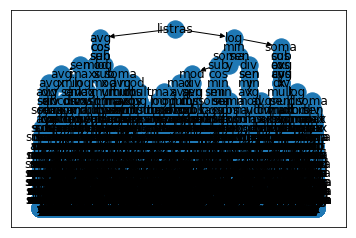

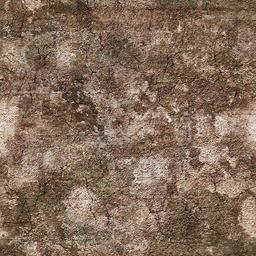

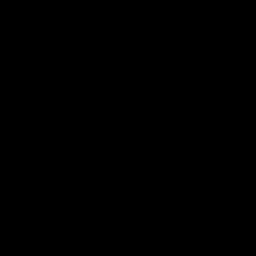

In [98]:
tree = gp.PrimitiveTree(hof[0])
compiledExpression = gp.compile(tree, pset)

print(hof[0])
plotTree(hof[0])
cv2_imshow(BASE_IMG)
cv2_imshow(compiledExpression(1, 17))
